In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.stats import linregress
%matplotlib notebook

In [2]:
df = pd.read_csv(os.path.join("..", "data", "streamflow", "ComalRv_Spgfl.csv"))
df.set_index(pd.to_datetime(df['datetime']), inplace=True)
df.dropna(inplace=True)
del df['datetime']
df.head()

,Comal River,Comal Springflow,MaxLevel_J17,MaxLevel_J27
datetime,,,,
2010-01-02,317.0,316.0,670.40,862.241
2010-01-03,317.0,315.0,670.30,862.249
2010-01-04,317.0,315.0,669.89,862.245
2010-01-05,317.0,314.0,669.62,862.253
2010-01-06,317.0,313.0,669.58,862.253


# Let's compare J-17 to Comal Springs

In [3]:
m = 2
print("Length before removing outliers: ", len(df))
for col in df.columns:
    std = np.std(df[col])
    df = df.loc[abs(df[col] - np.nanmean(df[col])) < m * std]
print("Length after removing outliers: ", len(df))

Length before removing outliers:  3194
Length after removing outliers:  3083


In [4]:
X_J17, y = np.array(df['MaxLevel_J17'].tolist()), np.array(df['Comal Springflow'].tolist()) # make these list like arrays
X_ComRv = np.array(df['Comal River'].tolist())
X_J27 = np.array(df['MaxLevel_J27'].tolist())

In [5]:
X = []

for i, row in df.iterrows():
    X_J17, X_ComRv, X_J27 = row['MaxLevel_J17'], row["Comal River"], row["Comal Springflow"]
    X.append([X_J17, X_ComRv, X_J27])

X = np.array(X)
X.shape

(3083, 3)

In [6]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.75, random_state=123)

# train_X = train_X.reshape(-1, 1)
# test_X  = test_X.reshape(-1, 1)
# train_y = train_y.reshape(-1, 1)
# test_y  = test_y.reshape(-1, 1)

print("Labels for training and testing data")
print("Train X shape: ", train_X.shape)
print("Train Y shape: ", train_y.shape)
print("Test  X shape: ", test_X.shape)
print("Test  Y shape: ", test_y.shape)

Labels for training and testing data
Train X shape:  (770, 3)
Train Y shape:  (770,)
Test  X shape:  (2313, 3)
Test  Y shape:  (2313,)


In [7]:
from sklearn import linear_model
from sklearn.svm import SVR

svr = SVR(gamma='scale', C=1.0, epsilon=0)
svr.fit(train_X, train_y) 

k = 20 
knn = KNeighborsRegressor(n_neighbors=k) 
knn.fit(train_X, train_y)

clf = linear_model.Lasso(alpha=0.1)
clf.fit(train_X, train_y)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [8]:
future_j17 = [[400]] # Springflow at Comal River
future_j17 = np.array(future_j17)

x_list = []
y_list = []
for i in range(len(X)):
    x_list.append(X[i])
    y_list.append(y[i])

x_list = np.array(x_list)
y_list = np.array(y_list)

print(x_list.shape)
print(y_list.shape)

(3083, 3)
(3083,)


In [9]:
y_pred_knn = knn.predict(x_list)
y_pred_clf = clf.predict(x_list)
y_pred_svr = svr.predict(x_list)

# print(y_pred)
print('--------------')
# print(train_X)
print("KNN: ", knn.score(test_X, test_y))
print("Lasso: ", clf.score(test_X, test_y))
print("SVR: ", svr.score(test_X, test_y))

--------------
KNN:  0.9933231483790322
Lasso:  0.9999992108928167
SVR:  0.7023992685229579


Slope:  0.9944248471552645
Intercept:  2.5664000293255356
R Value:  0.997197756349676
P Value:  0.0


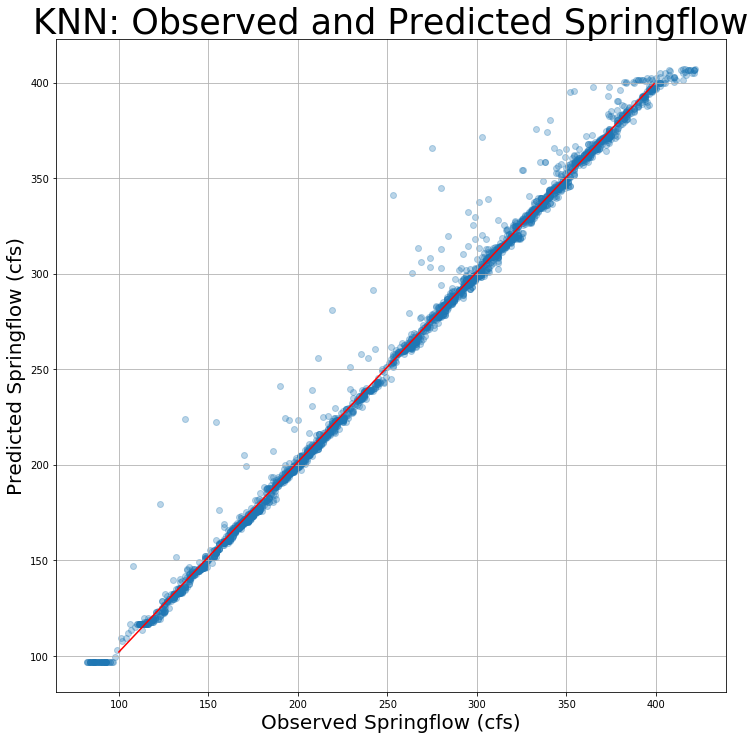

In [10]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(y_list, y_pred_knn, alpha=0.3)
slope, intercept, r_value, p_value, std_err = linregress(y_list, y_pred_knn)
print("Slope: ", slope)
print("Intercept: ", intercept)
print("R Value: ", r_value)
print("P Value: ", p_value)
regx = np.arange(100,400)
regy = slope*regx + intercept
ax.plot(regx,regy,color='r')

ax.set_title('KNN: Observed and Predicted Springflow', size=35)
ax.set_ylabel("Predicted Springflow (cfs)", size=20)
ax.set_xlabel("Observed Springflow (cfs)", size=20)
ax.grid()
plt.savefig(os.path.join("..", "img", "Springflow_pred_obs.png"))
plt.show()

Slope:  1.0000089562534031
Intercept:  0.0020221202417189943
R Value:  0.9999996574383015
P Value:  0.0


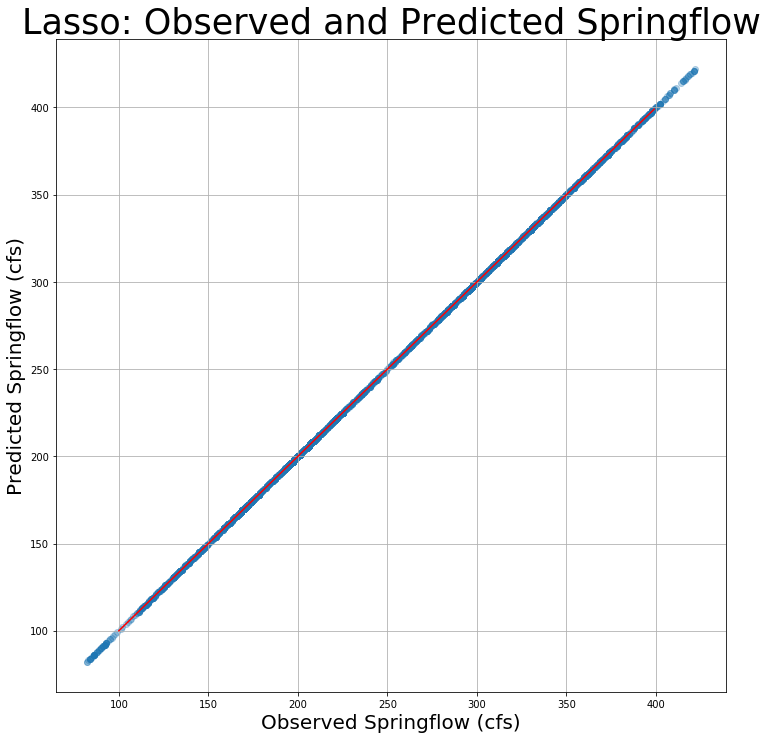

In [11]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(y_list, y_pred_clf, alpha=0.3)
slope, intercept, r_value, p_value, std_err = linregress(y_list, y_pred_clf)
print("Slope: ", slope)
print("Intercept: ", intercept)
print("R Value: ", r_value)
print("P Value: ", p_value)
regx = np.arange(100,400)
regy = slope*regx + intercept
ax.plot(regx,regy,color='r')

ax.set_title('Lasso: Observed and Predicted Springflow', size=35)
ax.set_ylabel("Predicted Springflow (cfs)", size=20)
ax.set_xlabel("Observed Springflow (cfs)", size=20)
ax.grid()
plt.savefig(os.path.join("..", "img", "Springflow_pred_obs.png"))
plt.show()

Slope:  0.5546305439274191
Intercept:  111.26073010101769
R Value:  0.8652880167656477
P Value:  0.0


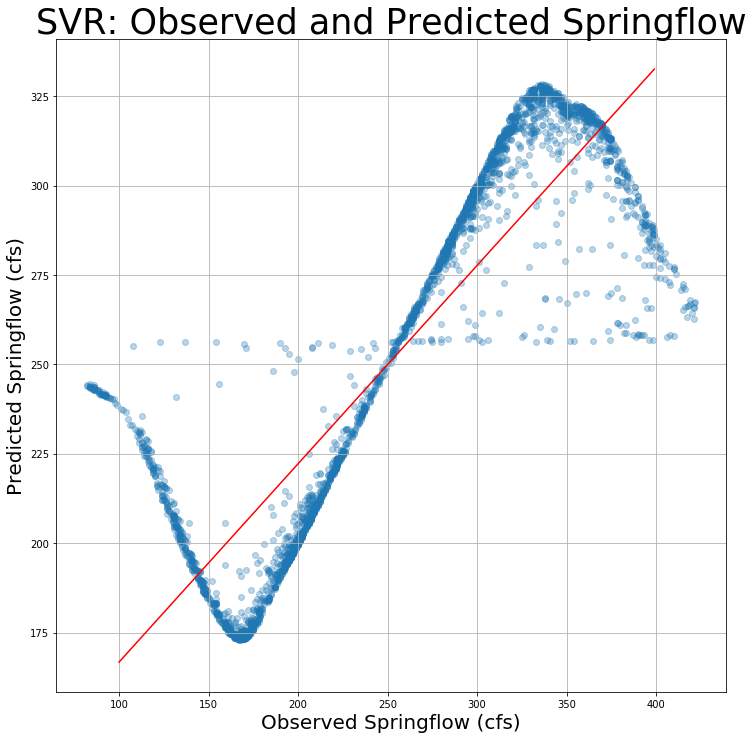

In [12]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(y_list, y_pred_svr, alpha=0.3)
slope, intercept, r_value, p_value, std_err = linregress(y_list, y_pred_svr)
print("Slope: ", slope)
print("Intercept: ", intercept)
print("R Value: ", r_value)
print("P Value: ", p_value)
regx = np.arange(100,400)
regy = slope*regx + intercept
ax.plot(regx,regy,color='r')

ax.set_title('SVR: Observed and Predicted Springflow', size=35)
ax.set_ylabel("Predicted Springflow (cfs)", size=20)
ax.set_xlabel("Observed Springflow (cfs)", size=20)
ax.grid()
plt.savefig(os.path.join("..", "img", "Springflow_pred_obs.png"))
plt.show()

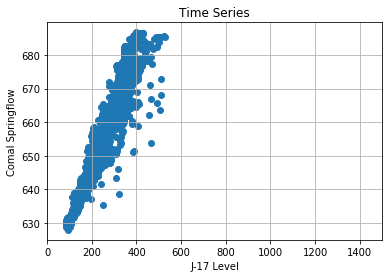

In [13]:
fig, ax = plt.subplots()
ax.set_xlim(0, 1500)
plt.scatter(df['Comal River'], df['MaxLevel_J17'])
ax.set_title('Time Series')
ax.set_ylabel("Comal Springflow")
ax.set_xlabel("J-17 Level")
ax.grid()
plt.savefig(os.path.join("..", "img", "J17_Comal_corr.png"))
plt.show()

# Let's examine Precipitation with Comal Springs

In [14]:
df_precip = pd.read_csv(os.path.join("..", "data", "precip", "NCDC", "output_stations", "US1TXGS0039.csv"))
df_precip.set_index(pd.to_datetime(df_precip['DATE']), inplace=True)
df.dropna(inplace=True)
df_precip = df_precip[["STATION", "NAME", "PRCP"]]
df_precip.head()

,STATION,NAME,PRCP
DATE,,,
2012-10-25,US1TXGS0039,"HARPER 4.9 N, TX US",0.00
2012-10-26,US1TXGS0039,"HARPER 4.9 N, TX US",0.00
2012-10-27,US1TXGS0039,"HARPER 4.9 N, TX US",0.17
2012-10-28,US1TXGS0039,"HARPER 4.9 N, TX US",0.00
2012-10-29,US1TXGS0039,"HARPER 4.9 N, TX US",0.00


In [15]:
df_precip = df_precip.merge(df, left_index=True, right_index=True)
df_precip = df_precip.shift(11)
df_precip.dropna(inplace=True)
df_precip.head()

,STATION,NAME,PRCP,Comal River,Comal Springflow,MaxLevel_J17,MaxLevel_J27
2012-11-05,US1TXGS0039,"HARPER 4.9 N, TX US",0.00,198.0,201.0,645.41,843.602
2012-11-06,US1TXGS0039,"HARPER 4.9 N, TX US",0.00,204.0,201.0,646.48,843.553
2012-11-07,US1TXGS0039,"HARPER 4.9 N, TX US",0.17,201.0,203.0,647.53,843.563
2012-11-08,US1TXGS0039,"HARPER 4.9 N, TX US",0.00,207.0,202.0,648.10,843.592
2012-11-09,US1TXGS0039,"HARPER 4.9 N, TX US",0.00,201.0,201.0,647.49,843.641


In [16]:
X, y = np.array(df_precip['Comal Springflow'].tolist()), np.array(df_precip['PRCP'].tolist()) # make these list like arrays

In [17]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.5, random_state=123)

train_X = train_X.reshape(-1, 1)
test_X  = test_X.reshape(-1, 1)
train_y = train_y.reshape(-1, 1)
test_y  = test_y.reshape(-1, 1)

print("Labels for training and testing data")
print("Train X shape: ", train_X.shape)
print("Train Y shape: ", train_y.shape)
print("Test  X shape: ", test_X.shape)
print("Test  Y shape: ", test_y.shape)

Labels for training and testing data
Train X shape:  (419, 1)
Train Y shape:  (419, 1)
Test  X shape:  (419, 1)
Test  Y shape:  (419, 1)


In [18]:
k = 20 
knn = KNeighborsRegressor(n_neighbors=k) 
knn.fit(train_X, train_y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=20, p=2,
          weights='uniform')

In [19]:
future_springflow = [[200]] # Springflow at Comal River
future_springflow = np.array(future_springflow)

x_list = []
y_list = []
for i in range(len(X)):
    x_list.append([X[i]])
    y_list.append([y[i]])

In [20]:
y_pred = knn.predict(x_list)
# print(y_pred)
print('--------------')
# print(train_X)
print(knn.score(test_X, test_y))


--------------
-0.003808509840019792


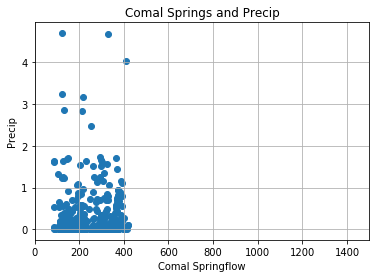

In [21]:
fig, ax = plt.subplots()
ax.set_xlim(0, 1500)
plt.scatter(df_precip['Comal Springflow'], df_precip['PRCP'])
ax.set_title('Comal Springs and Precip')
ax.set_xlabel("Comal Springflow")
ax.set_ylabel("Precip")
ax.grid()
plt.savefig(os.path.join("..", "img", "Springflow_PRCP.png"))
plt.show()